# Example notebook (simulated data)

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
from novaice.tl import ChemPertVAEModel, ChemPertMLPModel
import anndata as ad
import numpy as np
from lightning.pytorch.loggers import TensorBoardLogger

/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Generate example data

In [3]:
path = "/Users/michaelbaggiolorenz/Desktop/personal/BioHackathon_2025/nucleate-hackathon-2025/data/MCE_Bioactive_Compounds_HEK293T_10μM.h5ad"
adata = ad.read_h5ad(path)

### Train/Validation Split

The models will automatically create a train/validation split during training using the `validation_size` parameter.

## VAE

In [7]:
# Setup and train model with validation split
ChemPertVAEModel.setup_anndata(
    adata, 
    drug_embedding_key="foundation_embedding"
)
model = ChemPertVAEModel(adata)

# Create TensorBoard logger
tb_logger = TensorBoardLogger("logs", name="chempert_embedding_vae")

model.train(
    max_epochs=50,
    logger=tb_logger,
    log_every_n_steps=5,
    check_val_every_n_epoch=1,  # Validate every epoch
    train_size=0.8,  # Use 80% of data for training
    validation_size=0.2,  # Use 20% of data for validation
)
# Predict gene expression
predictions = model.predict_gene_expression()
# Get latent representation
latent = model.get_latent_representation()

INFO     Generating sequential column names                                                                        


/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in th

Epoch 50/50: 100%|██████████| 50/50 [03:45<00:00,  4.51s/it, v_num=0, train_loss=4.95e+3]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [03:45<00:00,  4.52s/it, v_num=0, train_loss=4.95e+3]


In [6]:
# Setup and train model with validation split
ChemPertVAEModel.setup_anndata(
    adata, 
    drug_embedding_key="morgan_fingerprint"
)
model = ChemPertVAEModel(adata)

# Create TensorBoard logger
tb_logger = TensorBoardLogger("logs", name="chempert_mf_vae")

model.train(
    max_epochs=50,
    logger=tb_logger,
    log_every_n_steps=5,
    check_val_every_n_epoch=1,  # Validate every epoch
    train_size=0.8,  # Use 80% of data for training
    validation_size=0.2,  # Use 20% of data for validation
)
# Predict gene expression
predictions = model.predict_gene_expression()
# Get latent representation
latent = model.get_latent_representation()

INFO     Generating sequential column names                                                                        


/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in th

Epoch 50/50: 100%|██████████| 50/50 [02:56<00:00,  3.69s/it, v_num=0, train_loss=4.49e+3]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, v_num=0, train_loss=4.49e+3]


In [8]:
model.get_prediction_error(method="r2")

array([0.72261071, 0.82665598, 0.82923162, ..., 0.7450704 , 0.35025173,
       0.79678279], shape=(40778,))

## Readback training and validation losses for both models and comparing

In [12]:
from tensorboard.backend.event_processing import event_accumulator
import os
import glob

def load_tensorboard_logs(log_dir):
    """Load metrics from TensorBoard event files"""
    # Find the latest version directory
    event_files = glob.glob(os.path.join(log_dir, "version_*", "events.out.tfevents.*"))
    if not event_files:
        raise ValueError(f"No event files found in {log_dir}")
    
    # Use the most recent event file
    latest_event_file = max(event_files, key=os.path.getctime)
    
    # Load the event file
    ea = event_accumulator.EventAccumulator(os.path.dirname(latest_event_file))
    ea.Reload()
    
    # Extract metrics
    metrics = {}
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        metrics[tag] = {
            'steps': [e.step for e in events],
            'values': [e.value for e in events]
        }
    
    return metrics

# Load metrics from both models
mf = load_tensorboard_logs("logs/chempert_mf_vae")
embed = load_tensorboard_logs("logs/chempert_embedding_vae")

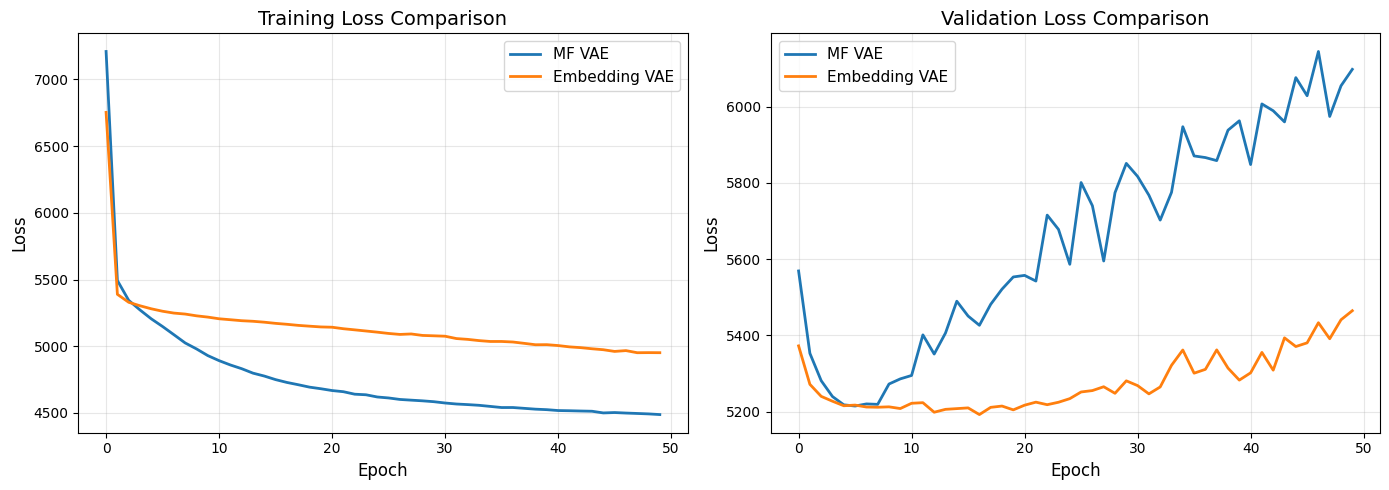

In [13]:
import matplotlib.pyplot as plt

# Try different possible keys for training loss
train_loss_keys = ['train_loss_epoch', 'train_loss', 'train/loss', 'loss']
val_loss_keys = ['validation_loss', 'val_loss', 'val/loss']

def get_loss_values(metrics, loss_keys):
    """Helper function to extract loss values from metrics"""
    for key in loss_keys:
        if key in metrics:
            return metrics[key]['values']
    return None

# Extract losses for both models
mf_train_loss = get_loss_values(mf, train_loss_keys)
mf_val_loss = get_loss_values(mf, val_loss_keys)
embed_train_loss = get_loss_values(embed, train_loss_keys)
embed_val_loss = get_loss_values(embed, val_loss_keys)

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss Comparison
if mf_train_loss:
    ax1.plot(mf_train_loss, label='MF VAE', linewidth=2, linestyle='-')
if embed_train_loss:
    ax1.plot(embed_train_loss, label='Embedding VAE', linewidth=2, linestyle='-')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Comparison', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Validation Loss Comparison
if mf_val_loss:
    ax2.plot(mf_val_loss, label='MF VAE', linewidth=2, linestyle='-')
if embed_val_loss:
    ax2.plot(embed_val_loss, label='Embedding VAE', linewidth=2, linestyle='-')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Validation Loss Comparison', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()